In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans Mono'
input_path = '../../input'

In [9]:
col_names = [
    'edibility',
    'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor', 
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
    'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring',
    'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color',
    'population', 'habitat'
]
feature_names = col_names[1:]
df = pd.read_csv(f'{input_path}/agaricus-lepiota.data', names=col_names)

In [10]:
df.head()

,edibility,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [12]:
df['edibility'].value_counts()

e    4208
p    3916
Name: edibility, dtype: int64

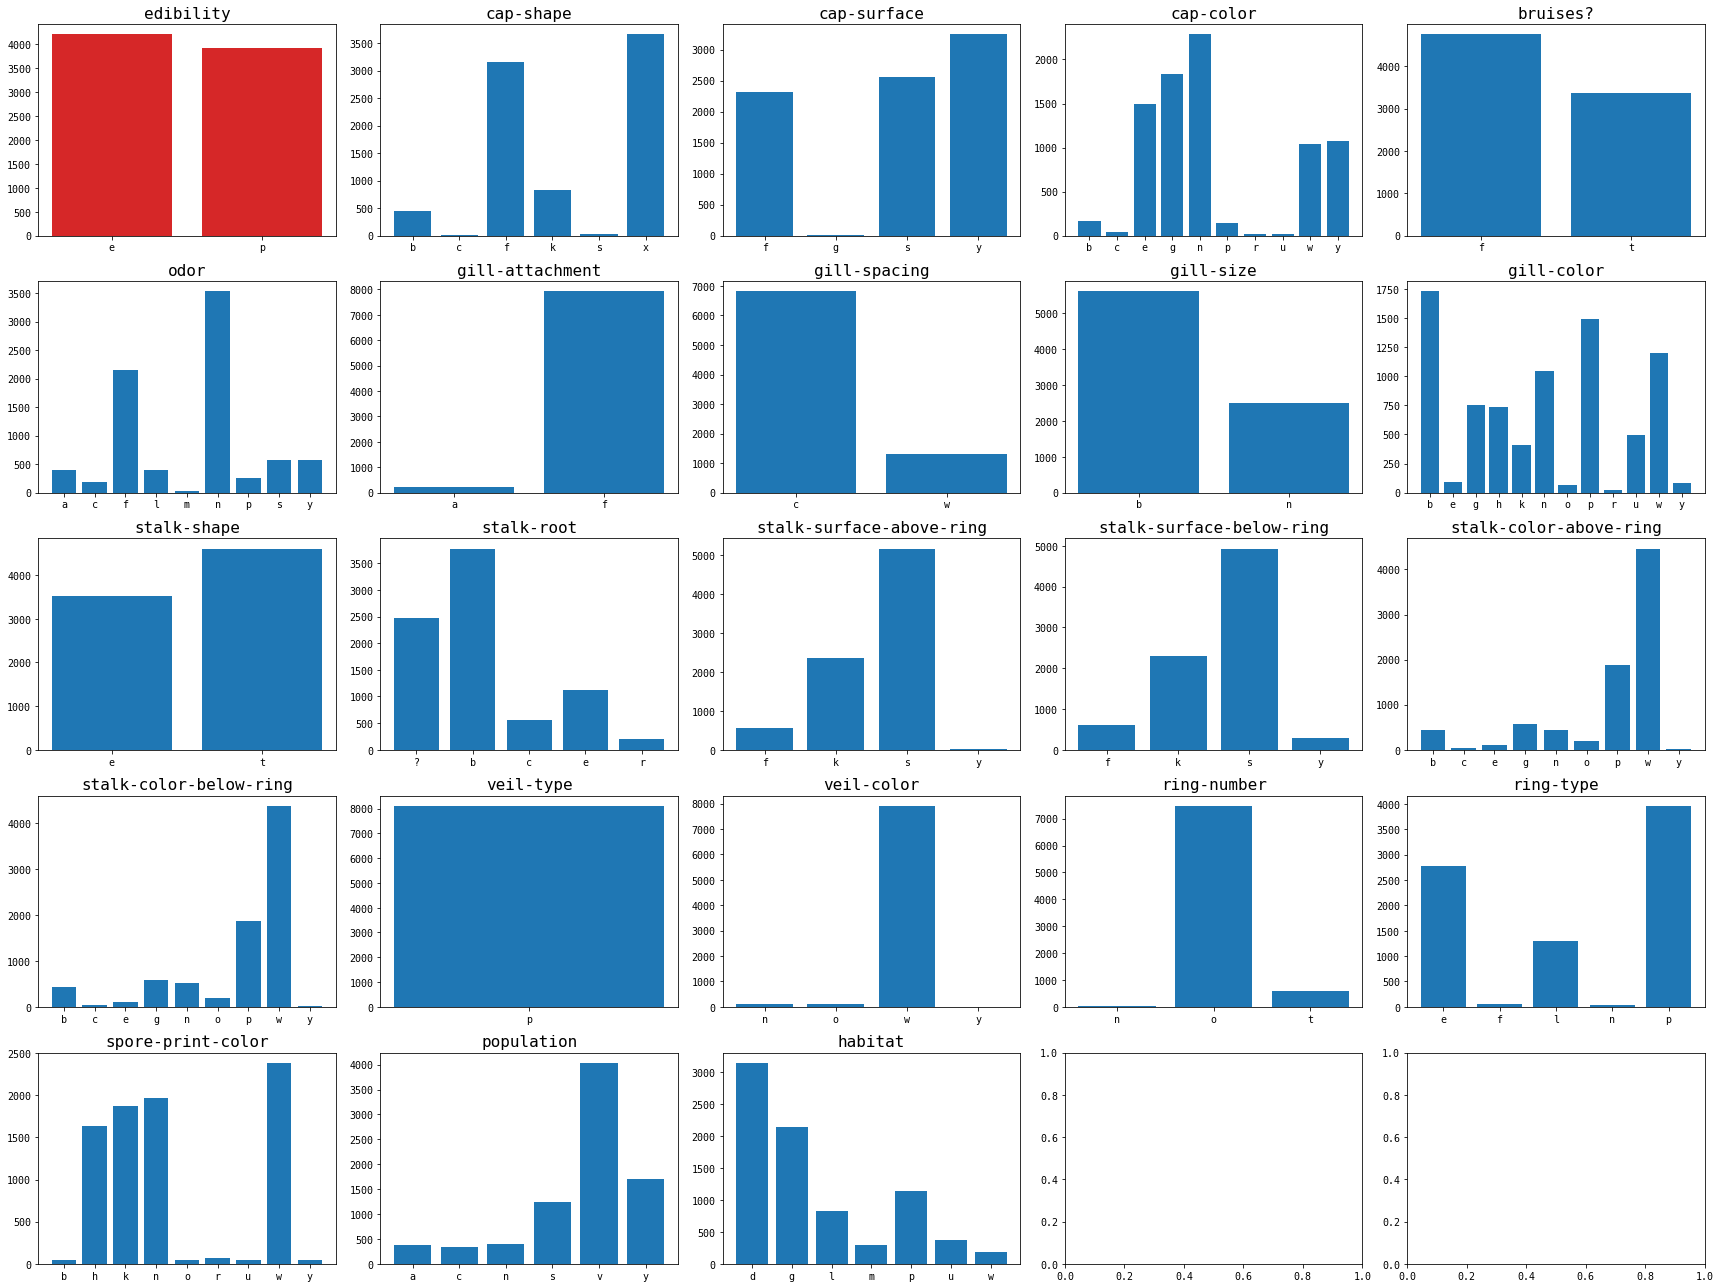

In [19]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(24, 18))
axs = axs.ravel()
for i in range(23):
    ax = axs[i]
    ser = df[col_names[i]].value_counts().sort_index()
    ax.bar(ser.index, ser, color=f'C{3*int(i==0)}')
    ax.set_title(col_names[i], fontsize=16)
plt.tight_layout(), plt.show(); plt.close()

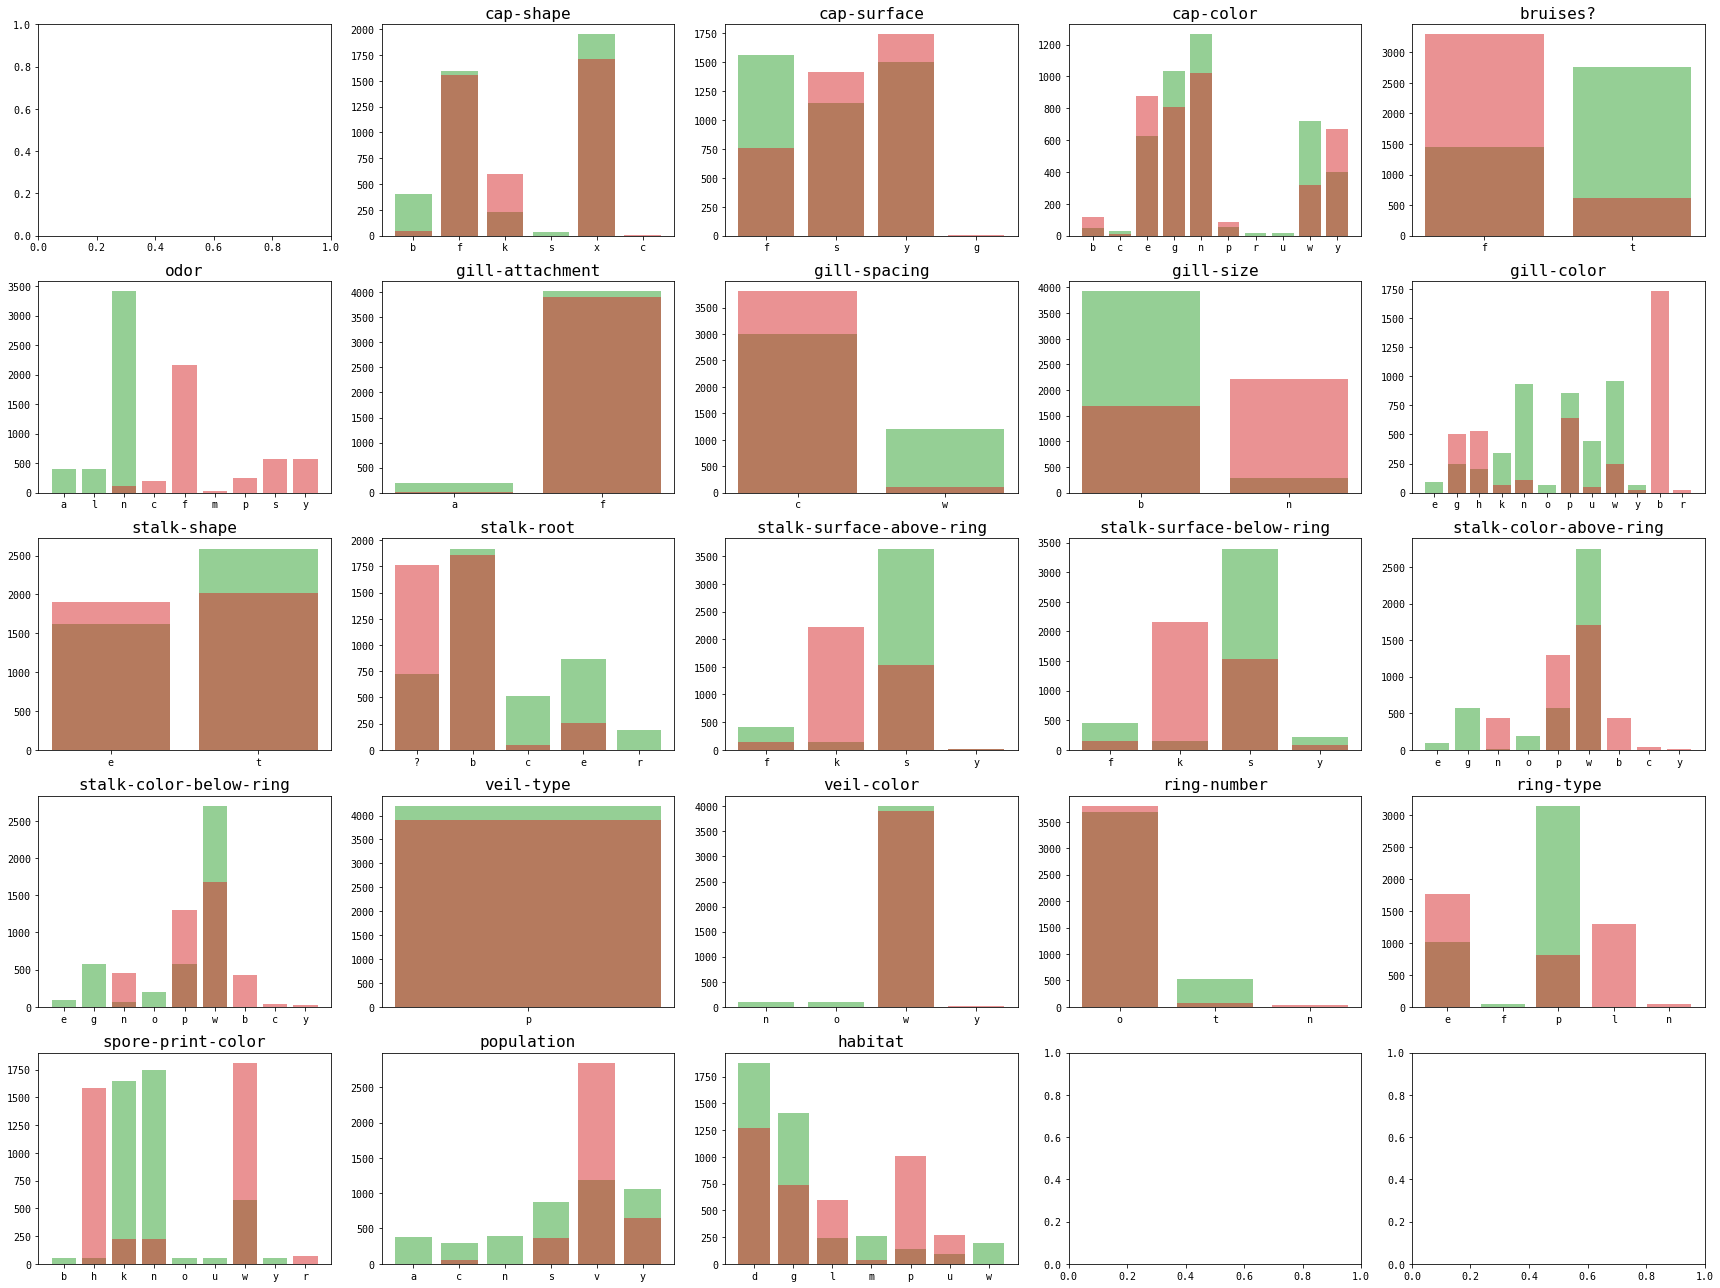

In [20]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(24, 18))
axs = axs.ravel()
for i in range(1, 23):
    ax = axs[i]
    ser = df.loc[df['edibility'] == 'e', col_names[i]].value_counts().sort_index()
    ax.bar(ser.index, ser, color=f'C2', alpha=0.5)

    ser = df.loc[df['edibility'] == 'p', col_names[i]].value_counts().sort_index()
    ax.bar(ser.index, ser, color=f'C3', alpha=0.5)
    ax.set_title(col_names[i], fontsize=16)
plt.tight_layout(), plt.show(); plt.close()